In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import datetime as dt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Загрузка данных

In [2]:
data_train = fetch_20newsgroups(subset='train', 
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', 
                               shuffle=False)

In [3]:
df_train, df_val, y_train, y_val = train_test_split(pd.DataFrame(data_train.data, columns=['text']),
                                                    data_train.target,
                                                    test_size=0.3, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_test = pd.DataFrame(data_test.data, columns=['text'])
y_test = data_test.target

### Предобработка

In [4]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download("punkt")

sw = set(get_stop_words("en"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kartsev.ES\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [6]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [7]:
tokens = word_tokenize(train_corpus)

In [8]:
tokens_filtered = [word for word in tokens if word.isalnum()]
dist = FreqDist(tokens_filtered)

In [9]:
def get_vocabulary(max_words):
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
    return vocabulary

In [10]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [11]:
def prepare_data(max_words, max_len):
    vocabulary = get_vocabulary(max_words)
    x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["text"]], dtype=np.int32)
    x_val = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_val["text"]], dtype=np.int32)
    x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["text"]], dtype=np.int32)
    print(f'x_train.shape: {x_train.shape}')
    print(f'x_val.shape: {x_val.shape}')
    print(f'x_test.shape: {x_test.shape}')
    return x_train, x_val, x_test, vocabulary

### Модель

In [12]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [15]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        if self.target is not None:
            y = np.zeros(20, dtype=float)
            y[self.target[index]] = 1
        else:
            y = None
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [16]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        train_preprocessing: преобразования тренировочных данных
        valid_preprocessing: преобразования валидационных данных
        
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество батчей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        
        optim: оптимизатор
        params_to_update: список обучаемых параметров
        
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f,
                 train_preprocessing=None,
                 valid_preprocessing=None,
                 learning_rate=1e-3, 
                 epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None,
                 device='cpu', early_stopping=10,
                 optim=torch.optim.Adam,
                 params_to_update=None,
                 scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        
        self.optim = optim
        self.params_to_update = params_to_update
        
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.train_preprocessing = train_preprocessing
        self.valid_preprocessing = valid_preprocessing
        
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []
    
    def predict(self, X):
        return self.best_model(X)

    def fit(self, train_dataset, train_labels, valid_dataset, valid_labels):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        if self.params_to_update is not None:
            optimizer = self.optim(self.params_to_update, lr=self.learning_rate)
        else:
            optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(train_dataset, train_labels, self.train_preprocessing)
        val = self.dataset(valid_dataset, valid_labels, self.valid_preprocessing)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

    def save_model(self, PATH):
        torch.save(self.best_model.state_dict(), PATH)

    def load_model(self, PATH):
         self.best_model.load_state_dict(torch.load(PATH))       
        
    def get_clf_results(self, test_dataset, test_labels):
        test = self.dataset(test_dataset, test_labels, self.valid_preprocessing)
        test = DataLoader(test, batch_size=self.batch_size, shuffle=False)
        
        true_labels = []
        pred_labels = []
        with torch.no_grad():
            for batch_X, labels in test:
                true_labels += list(labels.numpy())
                batch_X = batch_X.to(self.device)
                labels = labels.to(self.device)

                outputs = self.predict(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                pred_labels += list(predicted.numpy())
        return true_labels, pred_labels 

### Вариант 1

In [17]:
net = Net(vocab_size=2000, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 307860


In [18]:
x_train, x_val, x_test, vocabulary = prepare_data(2000, 40)

x_train.shape: (7919, 40)
x_val.shape: (3395, 40)
x_test.shape: (7532, 40)


In [19]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf1 = Trainer(**params)

In [20]:
clf1.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.892477789232808, 0:00:01.305438 сек
Loss_val: 2.591179370880127

Эпоха: 1 Loss_train: 2.3923472358334448, 0:00:01.263132 сек
Loss_val: 2.162706136703491

Эпоха: 2 Loss_train: 1.8974498702633766, 0:00:01.283223 сек
Loss_val: 1.8835948705673218

Эпоха: 3 Loss_train: 1.5010481784420628, 0:00:01.301340 сек
Loss_val: 1.5834225416183472

Эпоха: 4 Loss_train: 1.1928060958462376, 0:00:01.272587 сек
Loss_val: 1.3701037168502808

Эпоха: 5 Loss_train: 0.9501859872571884, 0:00:01.283834 сек
Loss_val: 1.2787593603134155

Эпоха: 6 Loss_train: 0.7483554549755589, 0:00:01.304140 сек
Loss_val: 1.167518138885498

Эпоха: 7 Loss_train: 0.587787504638395, 0:00:01.322534 сек
Loss_val: 1.1039100885391235

Эпоха: 8 Loss_train: 0.454951096926966, 0:00:01.314482 сек
Loss_val: 1.0657563209533691

Эпоха: 9 Loss_train: 0.3508532076112686, 0:00:01.303065 сек
Loss_val: 1.071459174156189

Эпоха: 10 Loss_train: 0.2682529824876016, 0:00:01.315749 сек
Loss_val: 1.0014381408691406

Эпоха: 11 Loss_t

In [21]:
true_labels, pred_labels = clf1.get_clf_results(x_test, y_test)

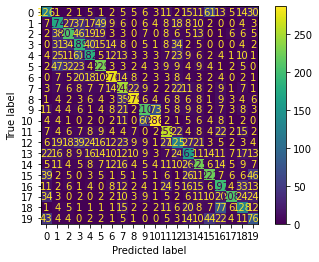

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot()

In [23]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.38      0.39      0.39       319
           1       0.43      0.45      0.44       389
           2       0.53      0.53      0.53       394
           3       0.41      0.48      0.44       392
           4       0.50      0.47      0.48       385
           5       0.57      0.58      0.58       395
           6       0.70      0.71      0.70       390
           7       0.53      0.63      0.57       396
           8       0.78      0.70      0.74       398
           9       0.58      0.53      0.55       397
          10       0.72      0.72      0.72       399
          11       0.61      0.65      0.63       396
          12       0.37      0.32      0.34       393
          13       0.43      0.41      0.42       396
          14       0.55      0.57      0.56       394
          15       0.56      0.56      0.56       398
          16       0.46      0.54      0.50       364
          17       0.78    

### Вариант 2

In [24]:
net = Net(vocab_size=2000, embedding_dim=256, out_channel=256, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 256)
  (conv): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=20, bias=True)
)
Parameters: 714004


In [25]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf2 = Trainer(**params)

In [26]:
clf2.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.6708354027040544, 0:00:03.226663 сек
Loss_val: 2.1437768936157227

Эпоха: 1 Loss_train: 1.6179502664073822, 0:00:03.073457 сек
Loss_val: 1.5806084871292114

Эпоха: 2 Loss_train: 1.0093960387091483, 0:00:03.084451 сек
Loss_val: 1.396848201751709

Эпоха: 3 Loss_train: 0.6204892944905066, 0:00:03.110625 сек
Loss_val: 1.3099467754364014

Эпоха: 4 Loss_train: 0.35324086825693807, 0:00:03.216397 сек
Loss_val: 1.1848269701004028

Эпоха: 5 Loss_train: 0.19483923263126804, 0:00:03.110122 сек
Loss_val: 1.1981743574142456

Эпоха: 6 Loss_train: 0.11092558455082678, 0:00:03.124910 сек
Loss_val: 1.2205407619476318

Эпоха: 7 Loss_train: 0.07127487659454346, 0:00:03.125932 сек
Loss_val: 1.247824788093567

Эпоха: 8 Loss_train: 0.050461026809869275, 0:00:03.137096 сек
Loss_val: 1.2714968919754028

Эпоха: 9 Loss_train: 0.03811503433051609, 0:00:03.115188 сек
Loss_val: 1.2589645385742188

Эпоха: 10 Loss_train: 0.031228714862898473, 0:00:03.070929 сек
Loss_val: 1.2735686302185059
5 б

In [27]:
true_labels, pred_labels = clf2.get_clf_results(x_test, y_test)

In [28]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.43      0.49      0.46       319
           1       0.50      0.53      0.52       389
           2       0.59      0.58      0.59       394
           3       0.51      0.47      0.49       392
           4       0.64      0.54      0.59       385
           5       0.63      0.65      0.64       395
           6       0.80      0.70      0.75       390
           7       0.59      0.66      0.62       396
           8       0.78      0.77      0.78       398
           9       0.61      0.63      0.62       397
          10       0.78      0.74      0.76       399
          11       0.69      0.69      0.69       396
          12       0.35      0.48      0.40       393
          13       0.57      0.53      0.55       396
          14       0.65      0.63      0.64       394
          15       0.58      0.55      0.56       398
          16       0.52      0.57      0.54       364
          17       0.78    

### Вариант 3

In [29]:
net = Net(vocab_size=2000, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 307860


In [30]:
x_train, x_val, x_test, vocabulary = prepare_data(2000, 60)

x_train.shape: (7919, 60)
x_val.shape: (3395, 60)
x_test.shape: (7532, 60)


In [31]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf3 = Trainer(**params)

In [32]:
clf3.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.863185082712481, 0:00:02.092023 сек
Loss_val: 2.559260368347168

Эпоха: 1 Loss_train: 2.319067701216667, 0:00:01.856185 сек
Loss_val: 2.0309574604034424

Эпоха: 2 Loss_train: 1.7641369450476863, 0:00:01.852767 сек
Loss_val: 1.606308937072754

Эпоха: 3 Loss_train: 1.358144248685529, 0:00:01.851885 сек
Loss_val: 1.4103556871414185

Эпоха: 4 Loss_train: 1.0650572132679723, 0:00:01.840635 сек
Loss_val: 1.2286466360092163

Эпоха: 5 Loss_train: 0.8412974178791046, 0:00:01.870742 сек
Loss_val: 1.225083827972412

Эпоха: 6 Loss_train: 0.6618785459187723, 0:00:01.860106 сек
Loss_val: 1.0982606410980225

Эпоха: 7 Loss_train: 0.5168377699390534, 0:00:01.852272 сек
Loss_val: 1.0875260829925537

Эпоха: 8 Loss_train: 0.40152754274106794, 0:00:01.841280 сек
Loss_val: 1.0213462114334106

Эпоха: 9 Loss_train: 0.3078325316309929, 0:00:01.830392 сек
Loss_val: 1.0045469999313354

Эпоха: 10 Loss_train: 0.23647708806299395, 0:00:01.838719 сек
Loss_val: 1.060035228729248

Эпоха: 11 Loss

In [33]:
true_labels, pred_labels = clf3.get_clf_results(x_test, y_test)

In [34]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.46      0.53      0.49       319
           1       0.53      0.50      0.52       389
           2       0.57      0.60      0.58       394
           3       0.53      0.52      0.52       392
           4       0.62      0.62      0.62       385
           5       0.67      0.61      0.63       395
           6       0.73      0.73      0.73       390
           7       0.60      0.66      0.63       396
           8       0.79      0.78      0.78       398
           9       0.63      0.61      0.62       397
          10       0.78      0.75      0.76       399
          11       0.71      0.73      0.72       396
          12       0.41      0.45      0.43       393
          13       0.50      0.48      0.49       396
          14       0.67      0.64      0.66       394
          15       0.59      0.63      0.61       398
          16       0.53      0.58      0.56       364
          17       0.85    

### Вариант 4

In [35]:
net = Net(vocab_size=4000, embedding_dim=256, out_channel=256, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(4000, 256)
  (conv): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=20, bias=True)
)
Parameters: 1226004


In [36]:
x_train, x_val, x_test, vocabulary = prepare_data(4000, 60)

x_train.shape: (7919, 60)
x_val.shape: (3395, 60)
x_test.shape: (7532, 60)


In [37]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf4 = Trainer(**params)

In [38]:
clf4.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.6810218134234027, 0:00:04.476097 сек
Loss_val: 2.0264363288879395

Эпоха: 1 Loss_train: 1.6076948238957314, 0:00:04.662622 сек
Loss_val: 1.4028271436691284

Эпоха: 2 Loss_train: 0.971497203073194, 0:00:04.642546 сек
Loss_val: 1.1022700071334839

Эпоха: 3 Loss_train: 0.5743025810487808, 0:00:04.633481 сек
Loss_val: 0.9899139404296875

Эпоха: 4 Loss_train: 0.3123614776038354, 0:00:04.625826 сек
Loss_val: 0.8539027571678162

Эпоха: 5 Loss_train: 0.16365678560349248, 0:00:04.889597 сек
Loss_val: 0.8046830296516418

Эпоха: 6 Loss_train: 0.09388700584250112, 0:00:04.720815 сек
Loss_val: 0.7860552072525024

Эпоха: 7 Loss_train: 0.060313482618620316, 0:00:05.082388 сек
Loss_val: 0.7936838865280151

Эпоха: 8 Loss_train: 0.042749378229341196, 0:00:04.699041 сек
Loss_val: 0.7911520004272461

Эпоха: 9 Loss_train: 0.03246233747490952, 0:00:04.703639 сек
Loss_val: 0.7571830749511719

Эпоха: 10 Loss_train: 0.025161583727646257, 0:00:04.643803 сек
Loss_val: 0.7604880928993225

Э

In [39]:
true_labels, pred_labels = clf4.get_clf_results(x_test, y_test)

In [40]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       319
           1       0.54      0.59      0.56       389
           2       0.65      0.62      0.64       394
           3       0.54      0.55      0.55       392
           4       0.66      0.62      0.64       385
           5       0.67      0.69      0.68       395
           6       0.81      0.70      0.75       390
           7       0.65      0.68      0.67       396
           8       0.80      0.79      0.80       398
           9       0.69      0.69      0.69       397
          10       0.80      0.81      0.81       399
          11       0.76      0.73      0.75       396
          12       0.38      0.50      0.43       393
          13       0.60      0.57      0.59       396
          14       0.78      0.70      0.74       394
          15       0.61      0.69      0.65       398
          16       0.62      0.64      0.63       364
          17       0.86    

In [41]:
def plot_loss():
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(clf1.train_loss)), clf1.train_loss, label='train 1', linestyle='--')
    plt.plot(range(len(clf1.val_loss)), clf1.val_loss, marker='o', label='val 1')
    plt.plot(range(len(clf2.train_loss)), clf2.train_loss, label='train 2', linestyle='--')
    plt.plot(range(len(clf2.val_loss)), clf2.val_loss, marker='o', label='val 2')
    plt.plot(range(len(clf3.train_loss)), clf3.train_loss, label='train 3', linestyle='--')
    plt.plot(range(len(clf3.val_loss)), clf3.val_loss, marker='o', label='val 3')
    plt.plot(range(len(clf4.train_loss)), clf4.train_loss, label='train 4', linestyle='--')
    plt.plot(range(len(clf4.val_loss)), clf4.val_loss, marker='o', label='val 4')
    plt.legend()
    plt.show()

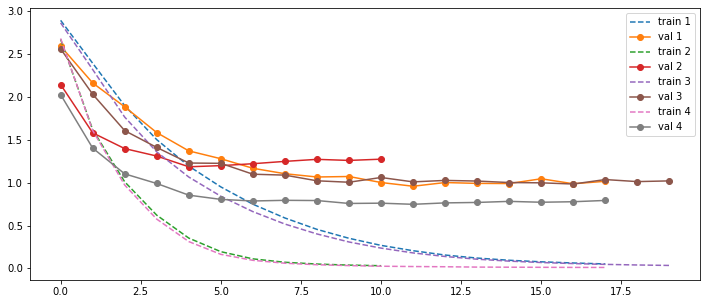

In [42]:
plot_loss()

__ВЫВОД:__ Как видно лучшие результаты показывает последняя модель.